In [157]:
%matplotlib inline

In [158]:
#export
from exp.nb_01 import *

def getMnistData():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(lambda data: tensor(data), (x_train,y_train,x_valid,y_valid))

def normalizeVector(vectorToNormalize, vectorMean, vectorStandardDeviation): 
    return (vectorToNormalize-vectorMean)/vectorStandardDeviation

def assertNearZero(someScalar,tol=1e-3): assert someScalar.abs()<tol, f"Near zero: {someScalar}"

In [159]:
def linearCombination(vector, matrix, biasVector): return vector @ matrix + biasVector
def reLU(vector): return vector.clamp_min(0.)

**Math Translation**

- **x** is the values that we are given (in this case it is a bunch of vectors that repersent images of numbers)
- **y** is the expected values that we want to predict (eg, is the image a "1" or "5")

In [160]:
xTrainingSet, yTrainingSet, xValidationSet, yValidationSet = getMnistData()

### Data Normalization

Data needs to be [normalized](https://en.wikipedia.org/wiki/Normalization_(statistics)) so that it reduces the impact of outliers on the data set.

One standard normaliziation is [standard score](https://en.wikipedia.org/wiki/Standard_score) which gives the data set a Gaussian Bell curve characteristic.

**This is how we will normalize the image data**


$$normalizedStandardScore ={value-mean  \over standardDeviation }$$

or in nerd words

$$z ={x-\mu \over \sigma}$$



In [161]:
xTrainingSetMean, xTrainingSetStandardDeviation = xTrainingSet.mean(), xTrainingSet.std()

In [162]:
(xTrainingSetMean, xTrainingSetStandardDeviation)

(tensor(0.1304), tensor(0.3073))

**Time to normalize**

In [163]:
xTrainingSetNormalized = normalizeVector(xTrainingSet, xTrainingSetMean, xTrainingSetStandardDeviation)

In [164]:
xValidationSetNormalized = normalizeVector(xValidationSet, xValidationSet.mean(), xValidationSet.std())

Now that our data has been normalized, we would expect the mean of the normalized data to be somewhere around zero, like the bell curve would assume.

![Bell Curve](./images/The_Normal_Distribution.png)

In [165]:
assertNearZero(xTrainingSetNormalized.mean())
assertNearZero(xValidationSetNormalized.mean())


The standard deviation, or $\sigma$ (sigma), of a **normalized distribution** should be 1.

In [166]:
assertNearZero(1 - xTrainingSetNormalized.std())
assertNearZero(1 - xValidationSetNormalized.std())

**Side Note**

Just because the data is normalized, does not change the fact that the images remain intact

In [167]:
# Change default color to plasma
plotter.rcParams['image.cmap'] = 'plasma'

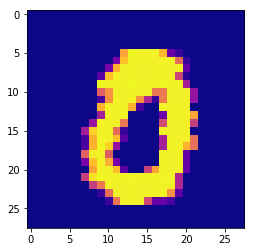

In [168]:
plotter.imshow(xTrainingSet[69].cpu().view(28,28))

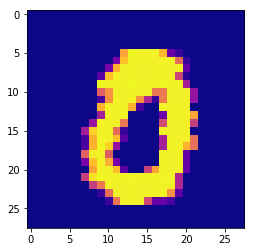

In [169]:
plotter.imshow(xTrainingSetNormalized[69].cpu().view(28,28))

#### Capture Data Set Dimensions

In [170]:
xRows, xColumns = xTrainingSetNormalized.shape
inputChannels = yTrainingSet.max() + 1
(xRows, xColumns, inputChannels)

(50000, 784, tensor(10))

### Convolutional Neural Network Setup

In [171]:
numberOfHiddenNodes = 50

#### Layer Initialization

Setting each layer in our convolutional network is important. Getting the right set of inital weights can lead to really good outputs. The following layer (done below) will have referenced the paper [Delving Deep into Rectifiers](https://arxiv.org/abs/1502.01852).

Paper Dictonary
---
- $c$ - Number of Input Channels
- $\operatorname {Var} [\vec{v}]$ - Variance of input vector, aka $\sigma ^{2}$ (sigma squared), 
- $\operatorname {E} [\vec{v}]$ - Mean of itput vector, aka $\mu$ (mu)
- $b$ - Bias Vector
- $n$ - Number of Columns

##### Section 2.2 Synopsis
Your weighted matrices should be initilaized such that the mean should be zero and the rest are symetrically dispresed around that mean (eg normalized).

**Simple Initialization**

Dividing the tensor by the number of total inputs of the each image brings the mean way down to zero. The distribution is also expected to have a standard deviation $\sigma$ (sigma) of 1.

In [172]:
weightedLayerOne = (torch.randn(xColumns, numberOfHiddenNodes) / math.sqrt(xColumns))
weightedLayerTwo = (torch.randn(numberOfHiddenNodes, 1) / math.sqrt(numberOfHiddenNodes))

In [173]:
assertNearZero(weightedLayerOne.mean())
assertNearZero(weightedLayerOne.std() - 1/math.sqrt(xColumns))

> We also initialize $b$ = 0.

In [174]:
biasVectorLayerOne = torch.zeros(numberOfHiddenNodes)
biasVectorLayerTwo = torch.zeros(1)

Any linear combination of the initialized layers should have a $\mu$=0 and $\sigma$=1 because $y$ is just a linear combination of $\vec{x}W + \vec{b}$

In [175]:
assertNearZero(xValidationSetNormalized.mean())
assertNearZero(1 - xValidationSetNormalized.std())

In [176]:
xValidationSetNormalized.shape, weightedLayerOne.shape

(torch.Size([10000, 784]), torch.Size([784, 50]))

In [177]:
linearWomboCombo = linearCombination(xValidationSetNormalized, weightedLayerOne, biasVectorLayerOne)

**Kaiming Note:**
These should be close to zero because of our initializaitons, but this appears to not be the case.

_The same goes for `reLU` processed vectors_

In [178]:
linearWomboCombo.mean(), linearWomboCombo.std()

(tensor(-0.0629), tensor(0.9759))

In [179]:
reLUWomboCombo = reLU(linearCombination(xValidationSetNormalized, weightedLayerOne, biasVectorLayerOne))

In [180]:
reLUWomboCombo.mean(), reLUWomboCombo.std()

(tensor(0.3533), tensor(0.5589))

**Paper Revelation**

Apparently scaling the intialization matrix down by dividing it by it's standard deviation apparently helps a bunch.

>This leads to a zero-mean Gaussian distribution whose standard deviation (std) is $\sqrt {2/n}$

In [181]:
kaimingInitializedWeightedMatrixOne = (torch.randn(xColumns, numberOfHiddenNodes) * math.sqrt(2/xColumns))

In [182]:
assertNearZero(kaimingInitializedWeightedMatrixOne.mean())
assertNearZero(kaimingInitializedWeightedMatrixOne.std() - 1 * math.sqrt(2/xColumns))

**Success!**
Now we get to use the library method!

In [183]:
#export
from torch.nn import init

In [184]:
libraryKiamingWeightedMatrix = torch.zeros(xColumns, numberOfHiddenNodes)

In [185]:
init.kaiming_normal_(libraryKiamingWeightedMatrix, mode='fan_out')
assertNearZero(libraryKiamingWeightedMatrix.mean())
assertNearZero(libraryKiamingWeightedMatrix.std() - 1 * math.sqrt(2/xColumns))

In [186]:
testMatrix = torch.zeros(xColumns, numberOfHiddenNodes)

In [187]:
%timeit init.kaiming_normal_(testMatrix, mode='fan_out')

263 µs ± 3.59 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [188]:
%timeit torch.randn(xColumns, numberOfHiddenNodes) * math.sqrt(2/xColumns)

300 µs ± 3.85 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Getting closer to Ideal

Apparently the Ideal state for our outputs ofter reLU transformation is to have a mean of zero
    $$\mu \approx 0$$
And a standard deviation of one
    $$\sigma \approx 1$$

In [189]:
forwardPass = reLU(linearCombination(xValidationSetNormalized, 
                                     libraryKiamingWeightedMatrix, 
                                     biasVectorLayerOne))

In [190]:
forwardPass.mean(), forwardPass.std()

(tensor(0.5388), tensor(0.8203))

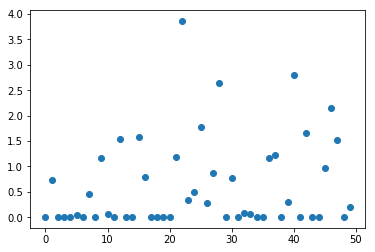

In [191]:
plotter.scatter(x=range(numberOfHiddenNodes), y=forwardPass[0].cpu())

In [192]:
def reLUEnhanced(vector): return vector.clamp_min(0.) - 0.5 # moves all the points above zero down to zero

In [193]:
enhancedForwardPass = reLUEnhanced(linearCombination(xValidationSetNormalized, 
                                                     libraryKiamingWeightedMatrix, 
                                                     biasVectorLayerOne))

**Shifting closer to zero**

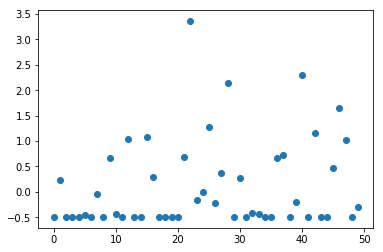

In [194]:
plotter.scatter(x=range(numberOfHiddenNodes), y=enhancedForwardPass[0].cpu())

In [195]:
enhancedForwardPass.mean(), enhancedForwardPass.std()

(tensor(0.0388), tensor(0.8203))

In [196]:
finalLibraryKiamingWeightedMatrix = torch.zeros(numberOfHiddenNodes, 1)

In [197]:
init.kaiming_normal_(finalLibraryKiamingWeightedMatrix, mode='fan_out')
print('dun')

dun


## Simple Forward Pass CNN Model


Take a look at what the input matrix's shape will be and then observe how the 2 weighted convolution matrices' shapes play into that.

In [198]:
xTrainingSetNormalized.shape, libraryKiamingWeightedMatrix.shape, finalLibraryKiamingWeightedMatrix.shape

(torch.Size([50000, 784]), torch.Size([784, 50]), torch.Size([50, 1]))

In [199]:
def simpleModel(inputMatrix):
    firstActivations = linearCombination(inputMatrix, 
                                         libraryKiamingWeightedMatrix, 
                                         biasVectorLayerOne)
    clampedFirstActivations = reLUEnhanced(firstActivations)
    lastActivations = linearCombination(clampedFirstActivations, 
                                        finalLibraryKiamingWeightedMatrix, 
                                        biasVectorLayerTwo)
    return lastActivations

In [200]:
%time predictions = simpleModel(xTrainingSetNormalized)

CPU times: user 183 ms, sys: 53.7 ms, total: 236 ms
Wall time: 69.6 ms


In [201]:
assert predictions.shape == torch.Size([xTrainingSetNormalized.shape[0], 1]), "{} does not equal {}".format(predictions.shape, torch.Size([xTrainingSetNormalized.shape[0], 1]))

### Getting ready to learn!
**Loss function**




In [202]:
#export
def assertSameShape(actualVector, expectedVector):
    assert actualVector.shape == expectedVector.shape, "Input vectors do not have the same shape! {} and {}".format(actualVector.shape, expectedVector.shape)
def meanSquaredError(actualVector, expectedVector):
    assertSameShape(actualVector, expectedVector)
    return (actualVector - expectedVector).pow(2).mean()
    

In [203]:
%time loss = meanSquaredError(predictions.squeeze(-1), yTrainingSet.float())

CPU times: user 1.47 ms, sys: 1.96 ms, total: 3.44 ms
Wall time: 1.06 ms


In [204]:
loss

tensor(31.7647)

The goal now is to minimize error, and we can do this by the process of backwards propagation.

**Taking the deriviative (finding the gradient of the slope) of the loss function**

*quick note*: `unsqueeze(-1)` will add a dimension to a vector eg `size([4])` -> `size([4, 1])` after unsqueezing

### Cost Gradient
This case, the cost is the mean squared error
So we want the gradient of the $\vec{C} = \vec{y} - \hat{y}$

For this example, the expected vector is **the digits the image data represents** (so 50000 digits) and the output vector is the predicted digit (for the 50000 of inputs).

$\vec{y} = validation vector$ (What digit the picture is)

$\vec{x} = input vector$ (Vector of images)

$\vec{w} = weighted vector$ (prediction layer)

$\hat{y} = \vec{x}\vec{w}$ (Digit predictions)

$\vec{C} = (\vec{y} - \hat{y})^2$ (Cost = mean squared error)

$\partial \vec{c} \over \partial \vec{w}$ $= 2(\vec{y} - \hat{y})$

---

$U_1(\vec{x}, \vec{w}) = \vec{x}\vec{w}$

$U_2(\vec{y}, U_1) = 2(\vec{y} - U_1)$

$C(U_2) = U_2^2$

$\partial \vec{c} \over \partial \vec{w}$ $= 2U_2$

---


$\hat{y}$ is going to be a vector that we predicted as the expected output

$cost = C$


**Things to keep in mind**

The gradient is calculated, only then can it be multiplied by the learning rate and then subtracted, so that it can move the weights of each activation layer in the right direction (lower loss).

So the following only calculates the gradient.

In [205]:
def meanSquaredErrorGradient(actualVector, expectedVector):
    squeezedActualVector = actualVector.squeeze()
    assertSameShape(squeezedActualVector, expectedVector)
    yHat = (squeezedActualVector - expectedVector)
    actualVector.storedGradients = 2. * yHat.unsqueeze(-1) / actualVector.shape[0]

**ReLU Gradient calculation**
We are going to take the gradients calculated from the gradients of the layer that comes after ReLU was called, and only take the gradients whose components have a greater than zero activation from the previous activation layer (the one called before it.

In [206]:
def reLUErrorGradient(previousActivations, nextActivations):
    previousActivations.storedGradients = (previousActivations > 0).float() * nextActivations.storedGradients

In [207]:
def linearCombinationErrorGradient(inputMatrix, activationMatrix, weightedMatrix, biasVector):
    inputMatrix.storedGradients = activationMatrix.storedGradients @ weightedMatrix.t() # t for transpose
    
    # Reduce the gradients from all of the images
    weightedMatrixGradients = (inputMatrix.unsqueeze(-1) * activationMatrix.storedGradients.unsqueeze(1)).sum(0)
    weightedMatrix.storedGradients = weightedMatrixGradients
    biasVector.storedGradients = activationMatrix.storedGradients.sum(0)

In [208]:
def churnThenLearn(testInputs, validationOutputs):
    #Churn
    firstLayerActivations = linearCombination(testInputs, 
                                              libraryKiamingWeightedMatrix, 
                                              biasVectorLayerOne)
    clampedFirstActivations = reLUEnhanced(firstLayerActivations)
    predictions = linearCombination(clampedFirstActivations, 
                                              finalLibraryKiamingWeightedMatrix, 
                                              biasVectorLayerTwo)
    
    loss = meanSquaredError(predictions.squeeze(-1), validationOutputs)
    print("Loss = {}".format(loss))
    
    #Learn
    meanSquaredErrorGradient(predictions, validationOutputs)
    linearCombinationErrorGradient(clampedFirstActivations, 
                                   predictions, 

                                   finalLibraryKiamingWeightedMatrix,
                                   biasVectorLayerTwo)
    reLUErrorGradient(firstLayerActivations, clampedFirstActivations)
    linearCombinationErrorGradient(testInputs, 
                                   firstLayerActivations, 
                                   libraryKiamingWeightedMatrix, 
                                   biasVectorLayerOne)
    return firstLayerActivations, predictions, biasVectorLayerOne, biasVectorLayerTwo, testInputs

In [209]:
libraryKiamingWeightedMatrix.storedGradients,biasVectorLayerOne.storedGradients,finalLibraryKiamingWeightedMatrix.storedGradients,biasVectorLayerTwo.storedGradients = [None]*4 




In [210]:
%time firstLayerActivations, finalLayerActivations, biasVectorLayerOne, biasVectorLayerTwo, testInputs = churnThenLearn(xTrainingSetNormalized, yTrainingSet.float())



Loss = 31.764667510986328
(torch.Size([50000, 50]), torch.Size([50000, 1]))
(torch.Size([50000, 784]), torch.Size([50000, 50]))
CPU times: user 11.1 s, sys: 24.8 s, total: 35.9 s
Wall time: 16.1 s


In [213]:
w1g = libraryKiamingWeightedMatrix.storedGradients.clone()
w2g = finalLibraryKiamingWeightedMatrix.storedGradients.clone()
b1g = biasVectorLayerOne.storedGradients.clone()
b2g = biasVectorLayerTwo.storedGradients.clone()
ig  = testInputs.storedGradients.clone()
xt2 = xTrainingSetNormalized.clone().requires_grad_(True)
w12 = libraryKiamingWeightedMatrix.clone().requires_grad_(True)
w22 = finalLibraryKiamingWeightedMatrix.clone().requires_grad_(True)
b12 = biasVectorLayerOne.clone().requires_grad_(True)
b22 = biasVectorLayerTwo.clone().requires_grad_(True)
def forward(inp, targ):
    # forward pass:
    l1 = inp @ w12 + b12
    l2 = reLUEnhanced(l1)
    out = l2 @ w22 + b22
    # we don't actually need the loss in backward!
    return meanSquaredError(out.squeeze(-1), targ)
loss = forward(xt2, yTrainingSet.float())
loss.backward()

In [215]:
testNear(w22.grad, w2g)
testNear(b22.grad, b2g)
testNear(w12.grad, w1g)
testNear(b12.grad, b1g)
testNear(xt2.grad, ig )

In [244]:
class ReLU():
    def __call__(self, activationMatrix):
        self.activationMatrix = activationMatrix
        self.activations = activationMatrix.clamp_(0.) - 0.5
        return self.activations
    
    def backwardsPropagation(self):
        self.activationMatrix.storedGradients = (self.activationMatrix > 0).float() * self.activations.storedGradients

In [223]:
class LinearCombo():
    def __init__(self, weightedMatrix, biasVector):
        self.weightedMatrix = weightedMatrix
        self.biasVector = biasVector
        
    def __call__(self, inputVector):
        self.inputVector = inputVector
        self.activationMatrix = self.inputVector @ self.weightedMatrix + self.biasVector
        return self.activationMatrix
    
    def backwardsPropagation(self):
        self.inputVector.storedGradients = self.activationMatrix.storedGradients @ self.weightedMatrix.t()
        weightedMatrixGradients = (self.inputVector.unsqueeze(-1) * self.activationMatrix.storedGradients.unsqueeze(1)).sum(0)
        self.weightedMatrix.storedGradients = weightedMatrixGradients
        self.biasVector.storedGradients = self.activationMatrix.storedGradients.sum(0)

In [232]:
class MeanSquaredError():
    def __call__(self, predictedVector, expectedVector):
        self.predictedVector = predictedVector
        self.expectedVector = expectedVector
        self.meanSquaredError = (self.predictedVector - self.expectedVector).pow(2).mean()
        return self.meanSquaredError
    
    def backwardsPropagation(self):
        squeezedActualVector = self.predictedVector.squeeze()
        assertSameShape(squeezedActualVector, self.expectedVector)
        yHat = (squeezedActualVector - self.expectedVector)
        self.predictedVector.storedGradients = 2. * yHat.unsqueeze(-1) / self.predictedVector.shape[0]

In [237]:
class CustomModel():
    def __init__(self, weightedLayerOne, weightedLayerTwo, biasVectorOne, biasVectorTwo):
        self.convolutionLayers = [LinearCombo(weightedLayerOne, biasVectorOne), ReLU(), LinearCombo(weightedLayerTwo, biasVectorTwo)]
        self.cost = MeanSquaredError()
    def __call__(self, normalizedInputs, expectedOutputs):
        activations = normalizedInputs
        for layer in self.convolutionLayers: activations = layer(activations)
        return self.cost(activations, expectedOutputs)
        
    def backwardsPropagation(self):
        self.cost.backwardsPropagation()
        for layer in reversed(self.convolutionLayers): layer.backwardsPropagation()

In [245]:
libraryKiamingWeightedMatrix.storedGradients,biasVectorLayerOne.storedGradients,finalLibraryKiamingWeightedMatrix.storedGradients,biasVectorLayerTwo.storedGradients = [None]*4 



In [246]:
model = CustomModel(libraryKiamingWeightedMatrix, finalLibraryKiamingWeightedMatrix, biasVectorLayerOne, biasVectorLayerTwo)

In [247]:
model(xTrainingSetNormalized, yTrainingSet.float())

tensor(30.9812)

In [248]:
model.backwardsPropagation()

In [252]:
model.convolutionLayers[2].weightedMatrix.storedGradients
print('dun')

dun


In [253]:
customeModelWeightedLayer2Gradients = model.convolutionLayers[2].weightedMatrix.storedGradients
customeModelBiasLayer2Gradients = model.convolutionLayers[2].biasVector.storedGradients
customeModelWeightedLayer1Gradients = model.convolutionLayers[0].weightedMatrix.storedGradients
customeModelBiasLayer1Gradients = model.convolutionLayers[0].biasVector.storedGradients
customeModelInputGradients = model.convolutionLayers[0].inputVector.storedGradients

In [254]:
testNear(w22.grad, customeModelWeightedLayer2Gradients)
testNear(b22.grad, customeModelBiasLayer2Gradients)
testNear(w12.grad, customeModelWeightedLayer1Gradients)
testNear(b12.grad, customeModelBiasLayer1Gradients)
testNear(xt2.grad, customeModelInputGradients)

In [257]:
class LinearComboEnhanced():
    def __init__(self, weightedMatrix, biasVector):
        self.weightedMatrix = weightedMatrix
        self.biasVector = biasVector
        
    def __call__(self, inputVector):
        self.inputVector = inputVector
        self.activationMsatrix = self.inputVector @ self.weightedMatrix + self.biasVector
        return self.activationMatrix
    
    def backwardsPropagation(self):
        self.inputVector.storedGradients = self.activationMatrix.storedGradients @ self.weightedMatrix.t()
        self.weightedMatrix.storedGradients = torch.einsum('ij,jk->ik', self.inputVector, self.activationMatrix.storedGradients)
        self.biasVector.storedGradients = self.activationMatrix.storedGradients.sum(0)

In [258]:
class CustomModelEnhanced():
    def __init__(self, weightedLayerOne, weightedLayerTwo, biasVectorOne, biasVectorTwo):
        self.convolutionLayers = [LinearCombo(weightedLayerOne, biasVectorOne), ReLU(), LinearCombo(weightedLayerTwo, biasVectorTwo)]
        self.cost = MeanSquaredError()
    def __call__(self, normalizedInputs, expectedOutputs):
        activations = normalizedInputs
        for layer in self.convolutionLayers: activations = layer(activations)
        return self.cost(activations, expectedOutputs)
        
    def backwardsPropagation(self):
        self.cost.backwardsPropagation()
        for layer in reversed(self.convolutionLayers): layer.backwardsPropagation()

In [259]:
libraryKiamingWeightedMatrix.storedGradients,biasVectorLayerOne.storedGradients,finalLibraryKiamingWeightedMatrix.storedGradients,biasVectorLayerTwo.storedGradients = [None]*4 



In [260]:
enhancedModel = CustomModelEnhanced(libraryKiamingWeightedMatrix, finalLibraryKiamingWeightedMatrix, biasVectorLayerOne, biasVectorLayerTwo)

In [261]:
enhancedModel(xTrainingSetNormalized, yTrainingSet.float())

tensor(30.9812)

In [262]:
enhancedModel.backwardsPropagation()

In [263]:
customEnhancedModelWeightedLayer2Gradients = enhancedModel.convolutionLayers[2].weightedMatrix.storedGradients
customEnhancedModelBiasLayer2Gradients = enhancedModel.convolutionLayers[2].biasVector.storedGradients
customEnhancedModelWeightedLayer1Gradients = enhancedModel.convolutionLayers[0].weightedMatrix.storedGradients
customEnhancedModelBiasLayer1Gradients = enhancedModel.convolutionLayers[0].biasVector.storedGradients
customEnhancedModelInputGradients = enhancedModel.convolutionLayers[0].inputVector.storedGradients

In [264]:
testNear(w22.grad, customEnhancedModelWeightedLayer2Gradients)
testNear(b22.grad, customEnhancedModelBiasLayer2Gradients)
testNear(w12.grad, customEnhancedModelWeightedLayer1Gradients)
testNear(b12.grad, customEnhancedModelBiasLayer1Gradients)
testNear(xt2.grad, customEnhancedModelInputGradients)

In [1]:
!python notebook2script.py 02_CNN_From_Scratch.ipynb

Converted 02_CNN_From_Scratch.ipynb to exp/nb_02.py
